In [162]:
!pip install torchmetrics

     -------------------------------------- 419.6/419.6 kB 5.2 MB/s eta 0:00:00


In [589]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms,models
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageFont, ImageDraw
from pathlib import Path
import pandas as pd
import cv2
import requests
from sklearn.metrics import f1_score
from torchmetrics import F1Score, Accuracy, ConfusionMatrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [ ]:
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
#random.seed(seed)


In [456]:
device = torch.device('cuda')
device=torch.device(device)

In [457]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [458]:

BATCH_SIZE = 64
learning_rate = 0.0001
EPOCHS = 10
numClasses = 205

In [459]:
# def collate_fn(batch):
#     return tuple(zip(*batch))


In [524]:
class TrafficData(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        self.image_ids = df['Path'].unique()
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index, size = [112, 112]):
        image_path = self.image_ids[index]
        records = self.df[self.df['Path'] == image_path]

        #print(f'{self.image_dir}/{image_path}')
        image = cv2.imread(f'{self.image_dir}/{image_path}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size)
        image = image.astype(float) / 255.0

        target = records['ClassId'].values

        if self.transforms:
            image = self.transforms(**image)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    @staticmethod
    def create_dataset(df, dir, transform=None):
       dataset = TrafficData(df, dir)
       return dataset

    @staticmethod 
    def loader(dataset, batch_size, shuffle=True, num_workers=0,):
       data_loader = DataLoader(
          dataset,
          batch_size=batch_size,
          shuffle=shuffle,
          num_workers=num_workers,
#           collate_fn = collate_fn
      )
       return data_loader


In [461]:
path = Path("Data_images")


In [462]:
df_train = pd.read_csv("Data_Images/Train_balanced_data.csv")
df_test = pd.read_csv("Data_images/Test_data_cleaned.csv")
df_inference = pd.read_csv('Data_images/data_inference.csv')

In [463]:

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])


In [464]:
train_data = TrafficData.create_dataset(df_train, path, data_transforms)
train_set, val_set = torch.utils.data.random_split(train_data, [29000, 6465])

train_data_loader = TrafficData.loader(train_set, BATCH_SIZE)
val_data_loader = TrafficData.loader(val_set, BATCH_SIZE)

test_data = TrafficData.create_dataset(df_test, path, data_transforms)
test_data_loader = TrafficData.loader(test_data, BATCH_SIZE)


In [465]:
images, targets = next(iter(test_data_loader))

In [466]:
len(train_data_loader.dataset)

29000

In [467]:
for X, y in test_data_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 112, 112, 3])
Shape of y: torch.Size([64, 1]) torch.int64


In [468]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [469]:
eff_net_b0 = models.efficientnet_b0(pretrained=True)

class Eff_net(nn.Module):
    def __init__(self, pretrained_model):
        super(Eff_net,self).__init__()
        self.Eff_net = pretrained_model
        #num_inputs = pretrained_model.classifier[1].in_features
        self.fl1 = nn.Linear(1000, 256)
        self.fl2 = nn.Linear(256, numClasses)
        
    def forward(self, X):
        X = self.Eff_net(X)
        X = F.relu(self.fl1(X))
        X = F.dropout(X, p=0.25)
        X = self.fl2(X)
        return X


E:\trafic_sign_classification\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\trafic_sign_classification\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [470]:
model = Eff_net(eff_net_b0)

In [471]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [472]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [473]:

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    top_pred = torch.reshape(top_pred, (-1,))
    true_pred = (top_pred == y).float().sum()
#     correct = top_pred.eq(y.view_as(top_pred)).sum()
#     acc = correct.float() / y.shape[0]
    return true_pred / len(y)

In [474]:
def calculate_f1_score(output,labels):
    predictions = output.argmax(1, keepdim = True)
    predictions = torch.reshape(predictions, (-1,))
    f1 = F1Score(num_classes=205).to(device)
    return f1(predictions, labels)


In [585]:
def join_batches_output(output,labels,overall_test_output,overall_test_labels):
    output = output.argmax(1, keepdim = True)
    output = torch.reshape(output, (-1,))
    overall_test_output = torch.cat((overall_test_output, output), 0)
    overall_test_labels = torch.cat((overall_test_labels, labels), 0)
    return overall_test_output,overall_test_labels

In [582]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for (images, labels) in loader:
        images = images.permute(0,3,1,2)
        images = images.float()
        labels = torch.reshape(labels, (-1,))
        images = images.cuda()
        labels = labels.cuda()
        
        opt.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        

        loss.backward()
        
        acc = calculate_accuracy(output, labels)
        
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)


In [586]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    overall_test_output = torch.Tensor([]).to(device)
    overall_test_labels = torch.Tensor([]).to(device)
    
    
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.permute(0,3,1,2)
            images = images.float()
            labels = torch.reshape(labels, (-1,))
            images = images.cuda()
            labels = labels.cuda()
            
            output = model(images)
            
            loss = criterion(output, labels)
            acc = calculate_accuracy(output, labels)
            f1_score = calculate_f1_score(output,labels)
            
            overall_test_output, overall_test_labels = join_batches_output(output,labels,overall_test_output,overall_test_labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1_score.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader), epoch_f1 / len(loader), overall_test_output, overall_test_labels

In [477]:
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
train_f1_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS
val_f1_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    val_f1_list[epoch] = val_f1
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, f1 = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_f1, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 2.7371, Accuracy = 0.4317, Time = 797.95 seconds
Validation: Loss = 0.4725, Accuracy = 0.8747, f1 = 0.8747, Time = 46.17 seconds

Epoch-1: 
Training: Loss = 0.3513, Accuracy = 0.9052, Time = 776.84 seconds
Validation: Loss = 0.1174, Accuracy = 0.9654, f1 = 0.9654, Time = 43.67 seconds

Epoch-2: 
Training: Loss = 0.1352, Accuracy = 0.9626, Time = 773.28 seconds
Validation: Loss = 0.0531, Accuracy = 0.9831, f1 = 0.9831, Time = 42.80 seconds

Epoch-3: 
Training: Loss = 0.0728, Accuracy = 0.9797, Time = 765.81 seconds
Validation: Loss = 0.0365, Accuracy = 0.9891, f1 = 0.9891, Time = 42.83 seconds

Epoch-4: 
Training: Loss = 0.0477, Accuracy = 0.9872, Time = 765.81 seconds
Validation: Loss = 0.0238, Accuracy = 0.9925, f1 = 0.9925, Time = 42.75 seconds

Epoch-5: 
Training: Loss = 0.0332, Accuracy = 0.9910, Time = 765.92 seconds
Validation: Loss = 0.0193, Accuracy = 0.9945, f1 = 0.9945, Time = 43.12 seconds

Epoch-6: 
Training: Loss = 0.0272, Accuracy = 0.9929, Time

In [304]:
# for epoch in range(10,EPOCHS):
#     print("Epoch-%d: " % (epoch))

#     train_start_time = time.monotonic()
#     train_loss, train_acc = train(model, train_data_loader, optimizer, criterion)
#     train_end_time = time.monotonic()

#     val_start_time = time.monotonic()
#     val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, optimizer, criterion)
#     val_end_time = time.monotonic()
    
# #     train_loss_list[epoch] = train_loss
# #     train_acc_list[epoch] = train_acc
# #     val_loss_list[epoch] = val_loss
# #     val_acc_list[epoch] = val_acc
# #     val_f1_list[epoch] = val_f1
    
#     print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
#     print("Validation: Loss = %.4f, Accuracy = %.4f, f1 = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_f1, val_end_time - val_start_time))
#     print("")

Epoch-10: 
Training: Loss = 0.1127, Accuracy = 0.9757, Time = 1420.73 seconds
Validation: Loss = 0.0440, Accuracy = 0.9881, f1 = 0.9881, Time = 53.62 seconds

Epoch-11: 
Training: Loss = 0.1389, Accuracy = 0.9727, Time = 1110.42 seconds
Validation: Loss = 0.1006, Accuracy = 0.9835, f1 = 0.9835, Time = 44.30 seconds

Epoch-12: 
Training: Loss = 0.1327, Accuracy = 0.9734, Time = 800.41 seconds
Validation: Loss = 0.0782, Accuracy = 0.9856, f1 = 0.9856, Time = 44.06 seconds

Epoch-13: 
Training: Loss = 0.0994, Accuracy = 0.9805, Time = 789.27 seconds
Validation: Loss = 0.0755, Accuracy = 0.9847, f1 = 0.9847, Time = 43.50 seconds

Epoch-14: 
Training: Loss = 0.0959, Accuracy = 0.9802, Time = 785.48 seconds
Validation: Loss = 0.1092, Accuracy = 0.9850, f1 = 0.9850, Time = 43.00 seconds



In [587]:
test_loss, test_acc, test_f1,overall_test_output, overall_test_labels = evaluate(model, test_data_loader, optimizer, criterion)
print("Validation: Loss = %.4f, Accuracy = %.4f, f1 = %.4f, Time = %.2f seconds" % (test_loss, test_acc, test_f1, val_end_time - val_start_time))
print("")

Validation: Loss = 0.1221, Accuracy = 0.9718, f1 = 0.9718, Time = 43.58 seconds



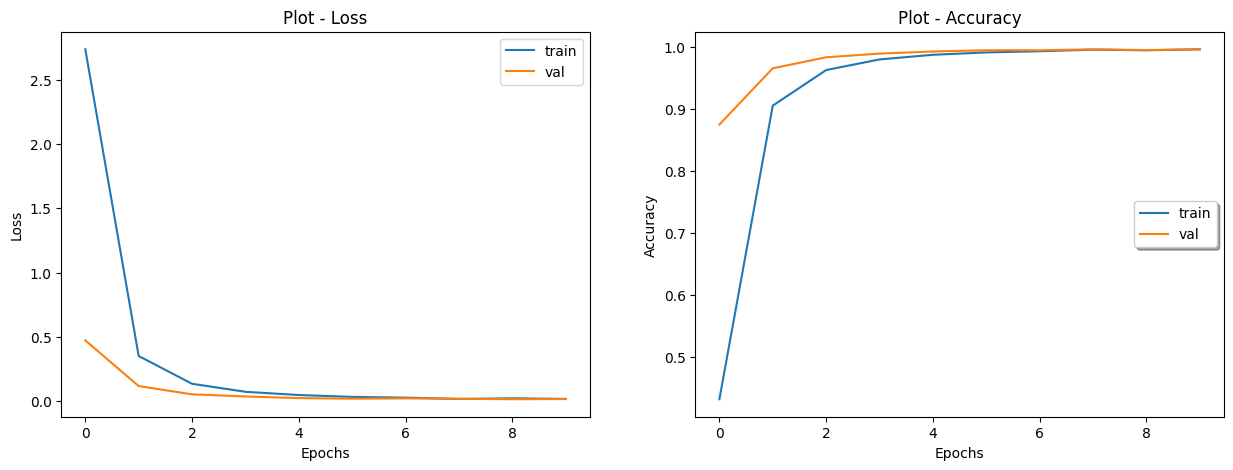

In [481]:
_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

In [482]:
torch.save(model, 'eff_model_saved1.pt')


In [483]:
the_model = torch.load('eff_model_saved1.pt')


In [554]:
inference_df = df_test.sample(5)
inference_data = TrafficData.create_dataset(inference_df, path, data_transforms)
inference_loader = TrafficData.loader(inference_data, 5, shuffle=False)

In [555]:
inference_df

,Unnamed: 0,ClassId,Path
6158,35049,122,Test/122_3_11.png
10610,14682,138,Test/138_5_29.png
12428,10821,145,Test/145_7_11.png
15964,6893,159,Test/159_7_2.png
32209,32724,62,Test/62_3_28.png


In [556]:
uris = list(inference_df['Path'])
uris = ['Data_images/' + s  for s in uris]
uris

['Data_images/Test/122_3_11.png',
 'Data_images/Test/138_5_29.png',
 'Data_images/Test/145_7_11.png',
 'Data_images/Test/159_7_2.png',
 'Data_images/Test/62_3_28.png']

In [557]:
def inference(model, loader):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.permute(0,3,1,2)
            images = images.float()
            labels = torch.reshape(labels, (-1,))
            images = images.cuda()
            labels = labels.cuda()
            
            output = model(images)
        return output, labels

In [558]:
output, labels = inference(the_model,inference_loader)

In [559]:
def get_predictions(output,labels):
    result = output.argmax(1, keepdim = True)
    result = torch.reshape(result, (-1,))
#     prob = (output[result]/sum(output))* 100
    
    return result, labels


In [560]:
result_class, labels = get_predictions(output,labels)

Text(0.5, 1.0, 'Predicted class: 62\n True class: 62')

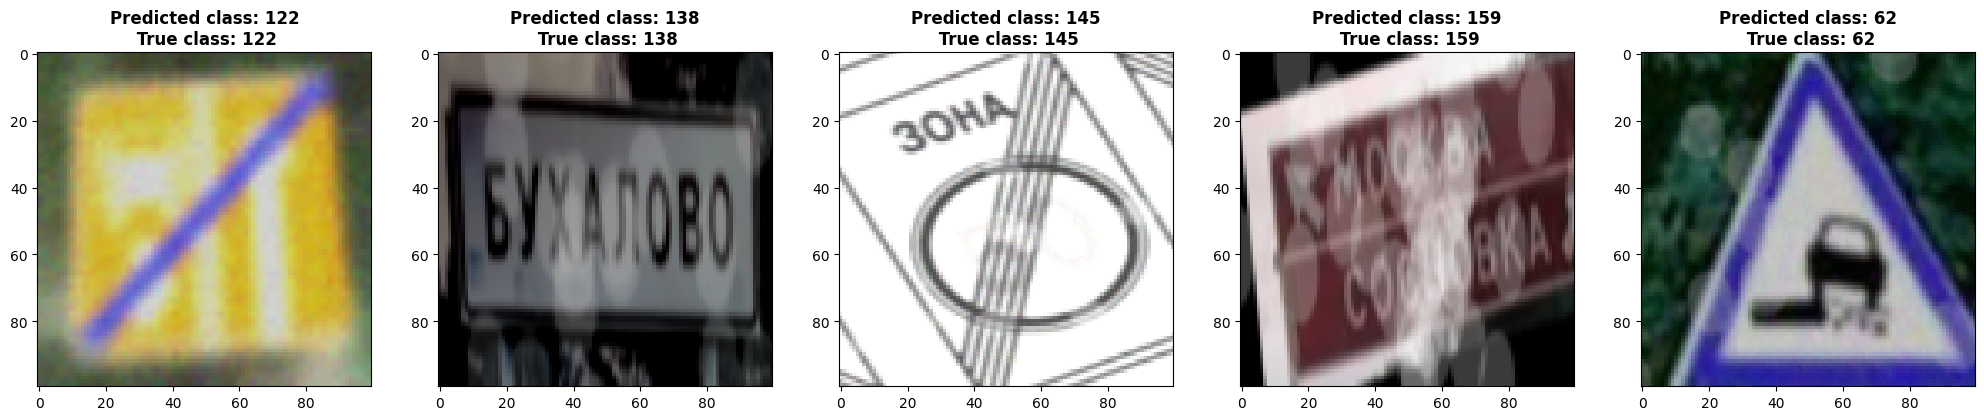

In [561]:
imgs = []
for i in range(len(uris)):
    img = cv2.imread(uris[i], cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, [100, 100])
    imgs.append(img)

fig, ax = plt.subplots(ncols=5, figsize=(25, 15))
ax[0].imshow(imgs[0], vmin=0, vmax=255)
ax[0].set_title('Predicted class: ' + str(result_class[0].item()) + '\n True class: ' + str(labels[0].item()), fontweight ="bold")
ax[1].imshow(imgs[1], vmin=0, vmax=255)
ax[1].set_title('Predicted class: ' + str(result_class[1].item()) + '\n True class: ' + str(labels[1].item()), fontweight ="bold")
ax[2].imshow(imgs[2], vmin=0, vmax=255)
ax[2].set_title('Predicted class: ' + str(result_class[2].item()) + '\n True class: ' + str(labels[2].item()), fontweight ="bold")
ax[3].imshow(imgs[3], vmin=0, vmax=255)
ax[3].set_title('Predicted class: ' + str(result_class[3].item()) + '\n True class: ' + str(labels[3].item()), fontweight ="bold")
ax[4].imshow(imgs[4], vmin=0, vmax=255)
ax[4].set_title('Predicted class: ' + str(result_class[4].item()) + '\n True class: ' + str(labels[4].item()), fontweight ="bold")


In [562]:
meta = list(inference_df['ClassId'])
meta = ['Data_images/Meta/' + str(s) + '.png'  for s in meta]
meta

['Data_images/Meta/122.png',
 'Data_images/Meta/138.png',
 'Data_images/Meta/145.png',
 'Data_images/Meta/159.png',
 'Data_images/Meta/62.png']

In [563]:
meta_imgs = []
for i in range(len(meta)):
    img = cv2.imread(meta[i], cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, [50, 50])
    meta_imgs.append(img)

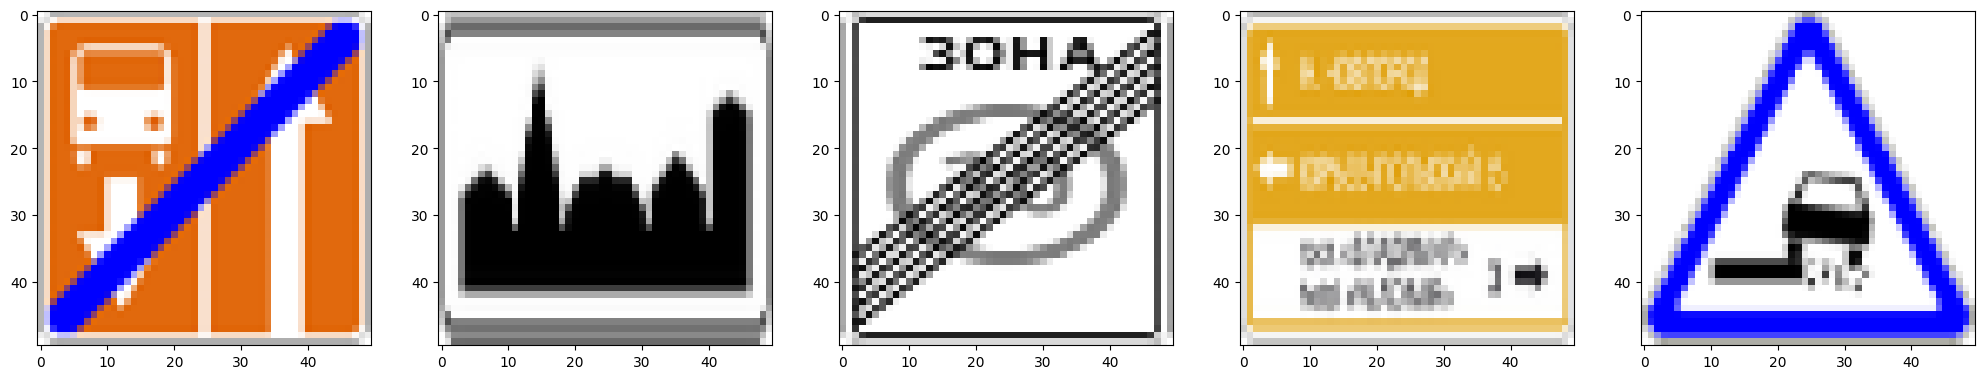

In [564]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 15))
ax[0].imshow(meta_imgs[0], vmin=0, vmax=255)
ax[1].imshow(meta_imgs[1], vmin=0, vmax=255)
ax[2].imshow(meta_imgs[2], vmin=0, vmax=255)
ax[3].imshow(meta_imgs[3], vmin=0, vmax=255)
ax[4].imshow(meta_imgs[4], vmin=0, vmax=255)


In [601]:
confmat = ConfusionMatrix(num_classes=205).to(device)
conf_m = confmat(overall_test_output.int(), overall_test_labels.int())
overall_test_output

tensor([111., 109., 198.,  ..., 129., 175., 126.], device='cuda:0')

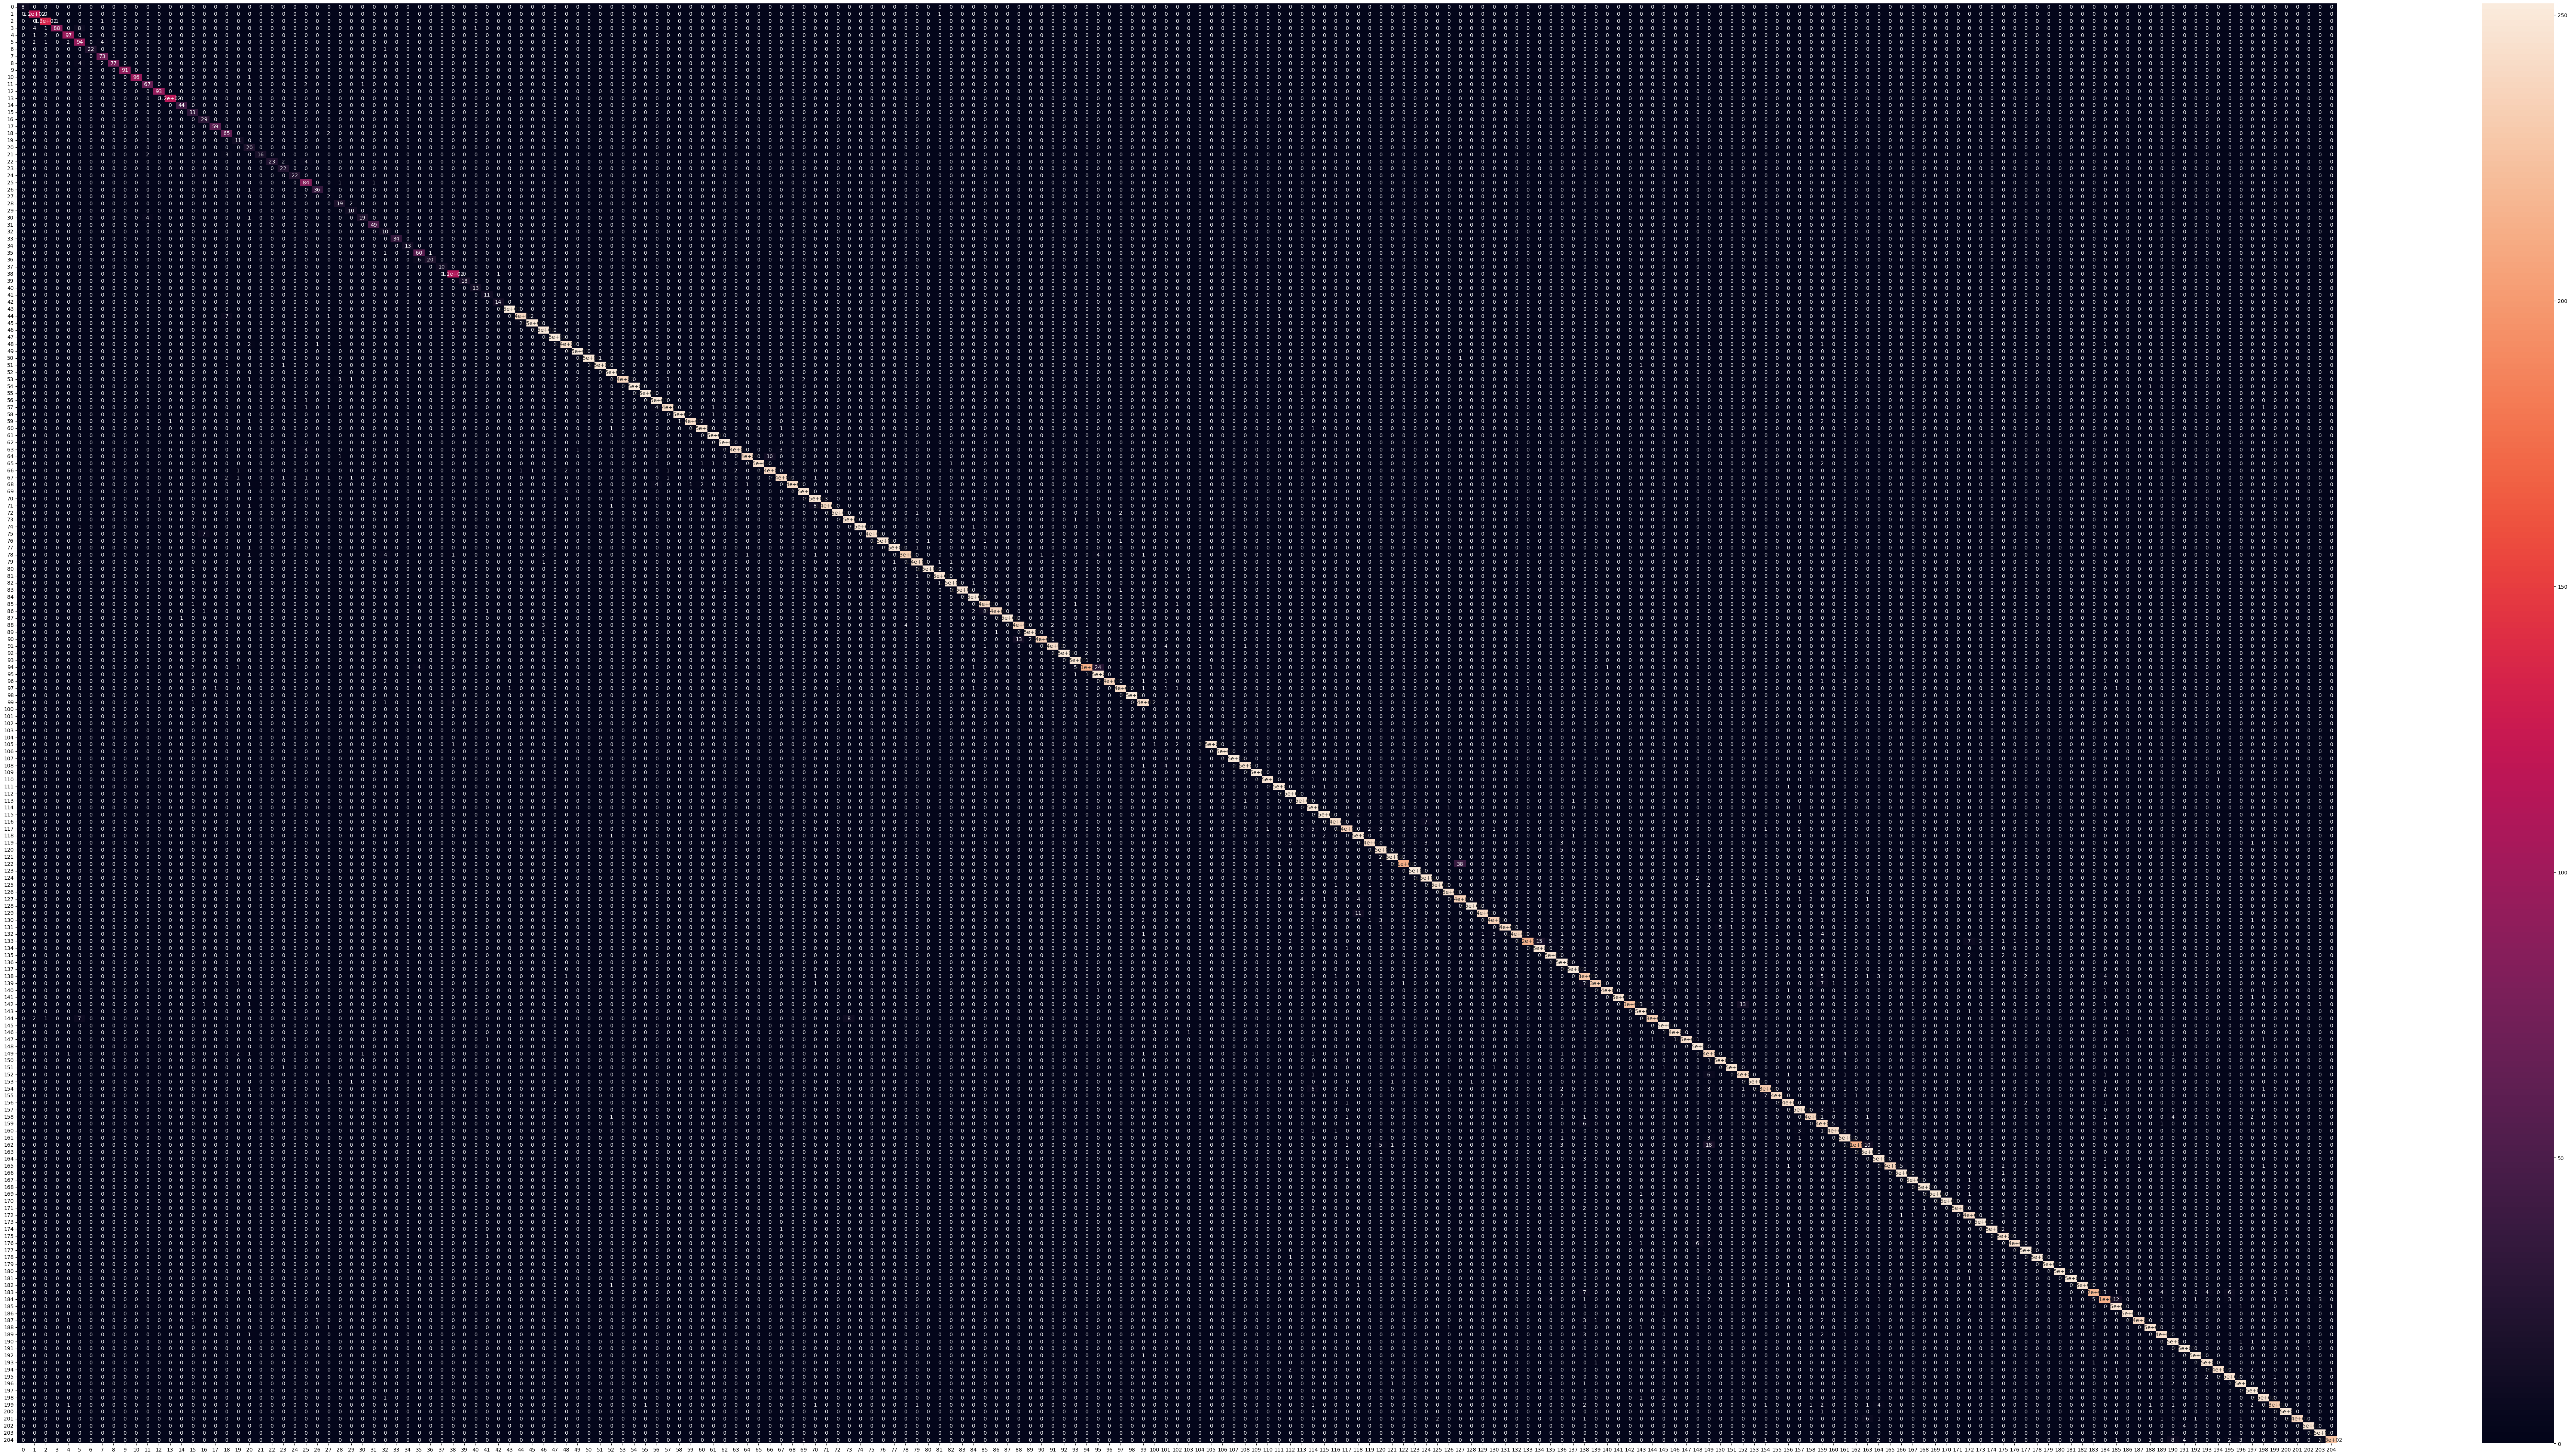

In [605]:
import seaborn as sns

plt.figure(figsize = (100,50))
sns.heatmap(conf_m.cpu(), annot=True)
plt.savefig('output.png')
